# 🦓 EDA + Validación + Export COCO Dataset
Notebook optimizado para CPU local (AMD Ryzen 7, Intel, etc.)

Permite:
- Cargar dataset en CSV o JSON COCO
- Analizar distribución de clases y tamaños de bounding boxes
- Detectar errores en anotaciones
- Convertir CSV → JSON COCO
- Sugerir anchor_sizes para Faster R-CNN
- (Opcional) Visualizar imágenes con sus cajas

In [ ]:
!pip install --user pandas numpy matplotlib seaborn opencv-python pycocotools tqdm

In [ ]:
!pip install --user --upgrade --force-reinstall numpy pandas

In [1]:
import os, json, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from pycocotools.coco import COCO
sns.set(style='whitegrid')
print('✅ Librerías cargadas')

✅ Librerías cargadas


In [2]:
# === 2️⃣ Parámetros de entrada ===
DATA_TYPE = 'csv'  # 'csv' o 'json'

# Rutas a tus archivos CSV
TRAIN_PATH = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\csv\train_big_size_A_B_E_K_WH_WB.csv'
VAL_PATH   = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\csv\val_big_size_A_B_E_K_WH_WB.csv'
TEST_PATH  = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\csv\test_big_size_A_B_E_K_WH_WB.csv'

# Rutas a las carpetas con imágenes
TRAIN_IMG_DIR = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\train'
VAL_IMG_DIR   = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\val'
TEST_IMG_DIR  = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\test'

# Carpeta donde se guardarán los JSON convertidos
OUTPUT_DIR = r'C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('📁 Directorios configurados correctamente')


📁 Directorios configurados correctamente


In [6]:
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    print(f'📄 CSV con {len(df)} registros')
    return df

def csv_to_coco(csv_path, images_dir, output_json):
    df = pd.read_csv(csv_path)
    images, annotations, categories = [], [], []
    category_map = {}

    for i, name in enumerate(sorted(df['Label'].unique())):
        category_map[name] = int(i + 1)
        categories.append({'id': int(i + 1), 'name': str(name)})

    img_id, ann_id = 0, 0
    for img_name, group in tqdm(df.groupby('Image')):
        img_path = os.path.join(images_dir, img_name)
        im = cv2.imread(img_path)
        if im is None:
            print(f'⚠️ No se pudo leer {img_name}')
            continue
        h, w = im.shape[:2]
        img_id += 1
        images.append({
            'id': int(img_id),
            'file_name': str(img_name),
            'height': int(h),
            'width': int(w)
        })

        for _, r in group.iterrows():
            x1, y1, x2, y2 = float(r['x1']), float(r['y1']), float(r['x2']), float(r['y2'])
            w_box, h_box = x2 - x1, y2 - y1
            if w_box <= 0 or h_box <= 0:
                continue
            ann_id += 1
            annotations.append({
                'id': int(ann_id),
                'image_id': int(img_id),
                'category_id': int(category_map[r['Label']]),
                'bbox': [x1, y1, w_box, h_box],
                'area': float(w_box * h_box),
                'iscrowd': 0
            })

    coco = {
        'info': {'description': 'Converted Dataset', 'year': 2025},
        'licenses': [],
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(coco, f, indent=2)
    print('✅ Guardado', output_json)


In [4]:
def analyze_boxes(df):
    df['width'] = df['x2'] - df['x1']
    df['height'] = df['y2'] - df['y1']
    stats = df[['width','height']].describe()
    print(stats)
    plt.figure(figsize=(6,4))
    sns.histplot(df['width'], color='skyblue', kde=True, label='width')
    sns.histplot(df['height'], color='orange', kde=True, label='height')
    plt.legend(); plt.title('Distribución de tamaños'); plt.show()
    return stats

def suggest_anchors(stats):
    avg = (stats.loc['mean','width'] + stats.loc['mean','height'])/2
    anchors = [8,16,32,64,128]
    print(f'📏 Promedio de objeto: {avg:.1f}px')
    print('🎯 anchor_sizes sugeridos:', anchors)

📄 CSV con 6962 registros
Label
6    2012
3    1732
1    1678
2    1058
4     316
5     166
Name: count, dtype: int64


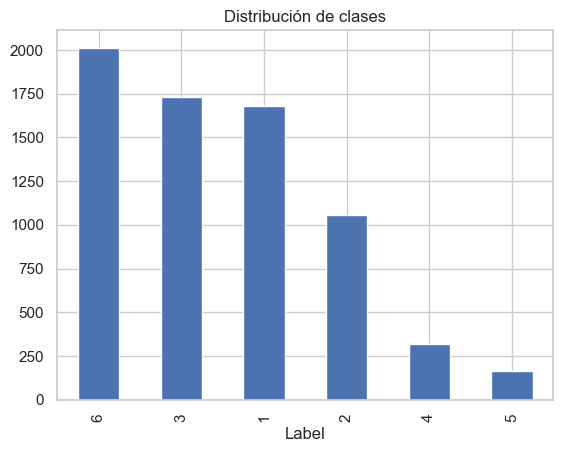

             width       height
count  6962.000000  6962.000000
mean     49.353634    48.062913
std      19.785552    20.027859
min       8.000000     6.000000
25%      35.000000    33.000000
50%      47.000000    45.000000
75%      61.000000    60.000000
max     148.000000   161.000000


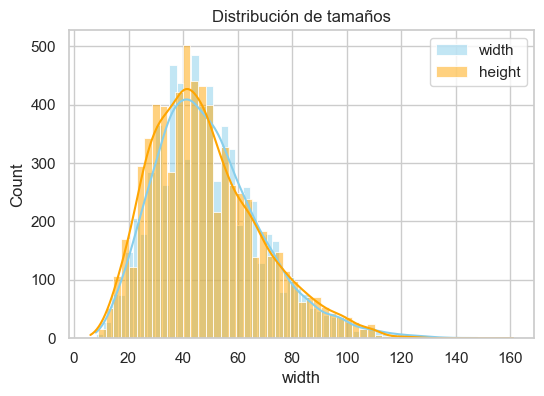

📏 Promedio de objeto: 48.7px
🎯 anchor_sizes sugeridos: [8, 16, 32, 64, 128]


100%|████████████████████████████████████████████████████████████████████████████████| 928/928 [06:03<00:00,  2.55it/s]


✅ Guardado C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\train_converted.json


In [7]:
df_train = load_csv(TRAIN_PATH)
print(df_train['Label'].value_counts())
df_train['Label'].value_counts().plot.bar(title='Distribución de clases')
plt.show()
stats = analyze_boxes(df_train)
suggest_anchors(stats)
csv_to_coco(TRAIN_PATH, TRAIN_IMG_DIR, os.path.join(OUTPUT_DIR,'train_converted.json'))

In [8]:
from pycocotools.coco import COCO

coco = COCO(os.path.join(OUTPUT_DIR, 'train_converted.json'))
print(f"📷 Imágenes: {len(coco.imgs)}")
print(f"📦 Anotaciones: {len(coco.anns)}")
print(f"🐾 Categorías: {len(coco.cats)} → {list(coco.cats.values())[:6]}")


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
📷 Imágenes: 928
📦 Anotaciones: 6962
🐾 Categorías: 6 → [{'id': 1, 'name': '1'}, {'id': 2, 'name': '2'}, {'id': 3, 'name': '3'}, {'id': 4, 'name': '4'}, {'id': 5, 'name': '5'}, {'id': 6, 'name': '6'}]


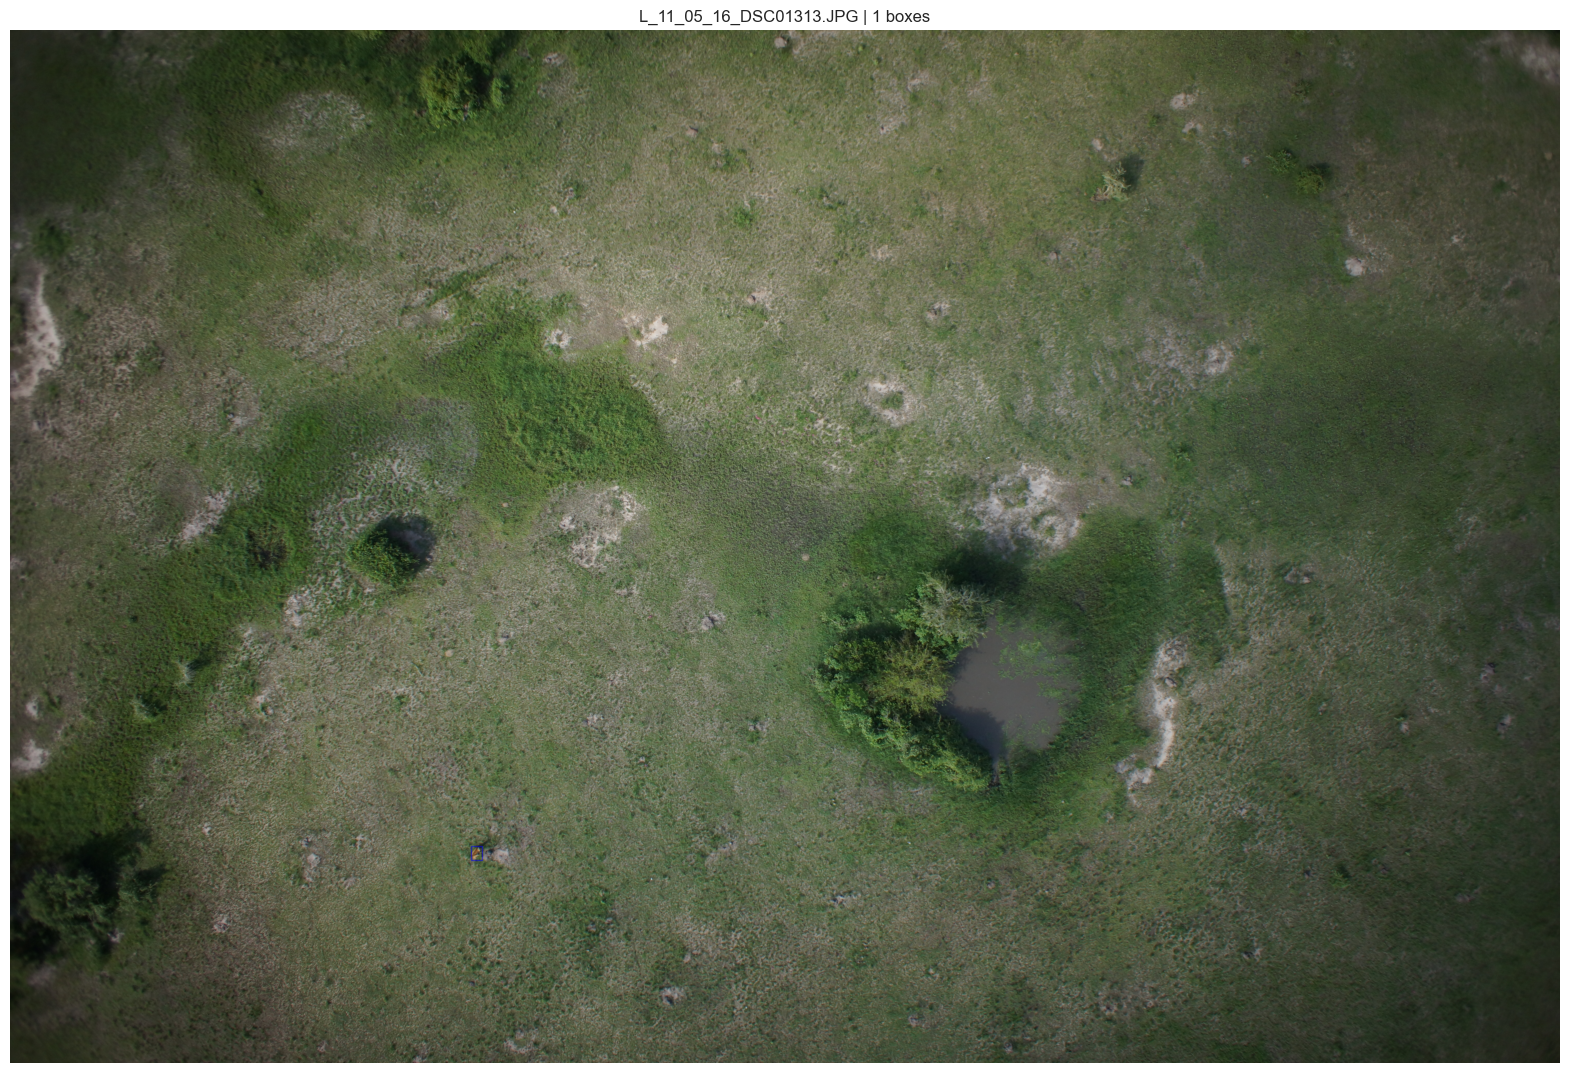

In [19]:
import random
import matplotlib.pyplot as plt
import cv2

# Paleta de colores por clase (1–6)
CLASS_COLORS = {
    1: (0, 0, 0),        # negro A
    2: (255, 0, 0),      # rojo Bufalo
    3: (0, 0, 255),      # azul Elefante
    4: (255, 255, 0),    # amarillo Kobi
    5: (0, 255, 255),    # azul claro WH
    6: (0, 255, 0)       # verde WB
}

def show_random_image(coco, img_dir, num_boxes=10):
    img_id = random.choice(list(coco.imgs.keys()))
    img_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    img_path = os.path.join(img_dir, img_info['file_name'])
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    ax = plt.gca()

    for ann in anns[:num_boxes]:
        x, y, w, h = ann['bbox']
        cat_id = ann['category_id']
        color = CLASS_COLORS.get(cat_id, (255, 255, 255))  # color por clase
        rect = plt.Rectangle(
            (x, y), w, h,
            fill=False,
            edgecolor=np.array(color)/255,  # normalizar a [0,1]
            linewidth=1,
            alpha=0.5
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.title(f"{img_info['file_name']} | {len(anns)} boxes")
    plt.show()

# Ejecutar visualización
show_random_image(coco, TRAIN_IMG_DIR)


In [20]:
csv_to_coco(VAL_PATH, VAL_IMG_DIR, os.path.join(OUTPUT_DIR, 'val_converted.json'))
csv_to_coco(TEST_PATH, TEST_IMG_DIR, os.path.join(OUTPUT_DIR, 'test_converted.json'))

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:44<00:00,  2.48it/s]


✅ Guardado C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\val_converted.json


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [01:48<00:00,  2.38it/s]

✅ Guardado C:\Users\licet\ProyectoGrado MAIA\general_dataset\general_dataset\groundtruth\json_converted\test_converted.json
